In [6]:
# Add "gfn_maxent_rl" to the path (only needed in notebook)
import sys
sys.path.insert(0, '..')

In [25]:
import wandb
import os
import hydra
import jax
import jax.numpy as jnp

from pathlib import Path
from numpy.random import default_rng

from gfn_maxent_rl.utils import io
from gfn_maxent_rl.utils.evaluations import get_samples_from_env
from gfn_maxent_rl.utils.estimation import estimate_log_probs_backward

In [3]:
api = wandb.Api()

wandb: WARNING Path :/home/mila/p/padideh.nouri/scratch/wandb/ wasn't writable, using system temp directory


In [15]:
run = api.run('tristandeleu_mila_01/gfn_maxent_rl/8s05x4ul')

In [16]:
# Check the algorithm (we need to pack the parameters)
run.config['exp_name_algorithm']

'dbv'

In [18]:
root = Path(os.getenv('SLURM_TMPDIR')) / run.id
run.file('model.npz').download(root=root, exist_ok=True)

# with open(root / 'model.npz', 'rb') as f:
#     params = DBVParameters(**io.load(f))

# # Patch
# params = jax.tree_util.tree_map(lambda x: x.item(), params)

<_io.TextIOWrapper name='/Tmp/slurm.4056223.0/8s05x4ul/model.npz' mode='r' encoding='UTF-8'>

In [19]:
with open(root / 'model.npz', 'rb') as f:
    data = io.load(f)
    params, state = data['params'], data['state']

In [20]:
env, infos = hydra.utils.instantiate(
    run.config['env'],
    num_envs=run.config['num_envs'],
    seed=run.config['seed'],
    rng=default_rng(run.config['seed']),
)

In [21]:
algorithm = hydra.utils.instantiate(run.config['algorithm'], env=env)

In [9]:
# # Patch
# net_state = DBVParameters(
#     policy={'~': {'normalization': jnp.array(1., dtype=jnp.float32)}},
#     flow={}
# )

In [23]:
key = jax.random.PRNGKey(run.config['seed'])
samples, returns = get_samples_from_env(
    env,
    algorithm,
    params,
    state,
    key,
    num_samples=1000,
    verbose=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
log_probs = estimate_log_probs_backward(
    env,
    algorithm,
    params,
    state,
    samples=samples,
    rng=default_rng(0),
    batch_size=2,
    num_trajectories=100,
    verbose=True
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
log_probs_values = jnp.array([log_probs[key] for key in log_probs.keys()])
log_probs_keys = [*log_probs.keys()]
samples_Return = returns

dict_samples = {}
for i, tree in enumerate(samples):
    dict_samples[tree] = samples_Return[i]

In [ ]:
# import pickle

# with open('dict_samples.pkl', 'wb') as f:
#     pickle.dump(dict_samples, f)

# with open('dict_log_probs.pkl', 'wb') as f:
#     pickle.dump(log_probs, f)

In [31]:
import matplotlib.pyplot as plt

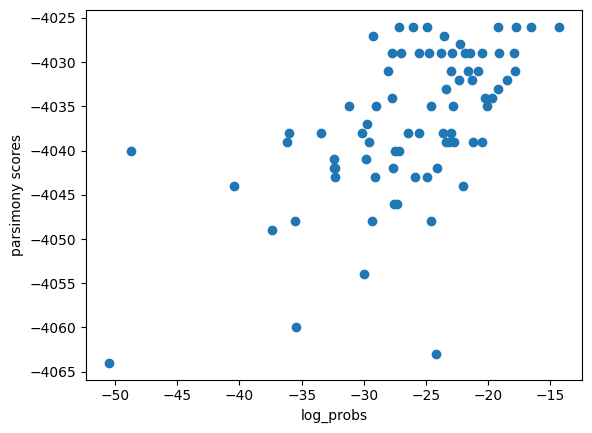

In [34]:
log_probs_list = []
Scores_list = []
for key in log_probs.keys():
    log_probs_list.append(log_probs[key])
    Scores_list.append(dict_samples[key])

plt.scatter(log_probs_list, Scores_list)
plt.xlabel('log_probs')
plt.ylabel('parsimony scores')

plt.savefig('my_plot.png')